# Perkenalan

===================================================================================================

Live Code 4

Nama  : Ciputra Wangsa

Batch : HCK - 020

Program ini dibuat untuk memprediksi popularity keywrods dari Pulau Pari selama satu minggu kedepan menggunakan model ARIMA dan SARIMA. Setelah diprediksi selanjutnya akan dilihat apakah trendnya turun atau naik lalu akan dibuat strategi untuk perusahaan travel.


===================================================================================================

# Import Libraries

In [257]:
# Load Library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Decomposition of time-series graph
import pylab
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

# Data Loading

In [258]:
# load data csv
df = pd.read_csv('multiTimeline.csv')
df

,Category: All categories
Week,Pulau Pari: (Indonesia)
2022-03-27,16
2022-04-03,13
2022-04-10,18
2022-04-17,29
...,...
2024-07-21,43
2024-07-28,34
2024-08-04,32
2024-08-11,36


In [259]:
# baris atas dataset
df.head()

,Category: All categories
Week,Pulau Pari: (Indonesia)
2022-03-27,16
2022-04-03,13
2022-04-10,18
2022-04-17,29


terdapat 2 kolom dan data awal dimulai dari tanggal 27 Maret 2022

In [260]:
# baris bawah dataset
df.tail()

,Category: All categories
2024-07-21,43
2024-07-28,34
2024-08-04,32
2024-08-11,36
2024-08-18,29


tanggal akhir dataset 18 Agustus 2024

In [261]:
# cek informasi dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 127 entries, Week to 2024-08-18
Data columns (total 1 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Category: All categories  127 non-null    object
dtypes: object(1)
memory usage: 2.0+ KB


Ada 127 baris data pada dataset, kolom category akan dihapus agar mempermudah visualisasi dan analisa.

In [262]:
# cek data duplikat
df.index.duplicated().sum()

0

Tidak ada data duplikat pada index

In [263]:
# cek missing value
df.isna().sum()

Category: All categories    0
dtype: int64

Tidak ada missing value 

In [264]:
# menghapus header kolom
df = df.rename(columns=df.iloc[0]).drop(df.index[0])

# EDA

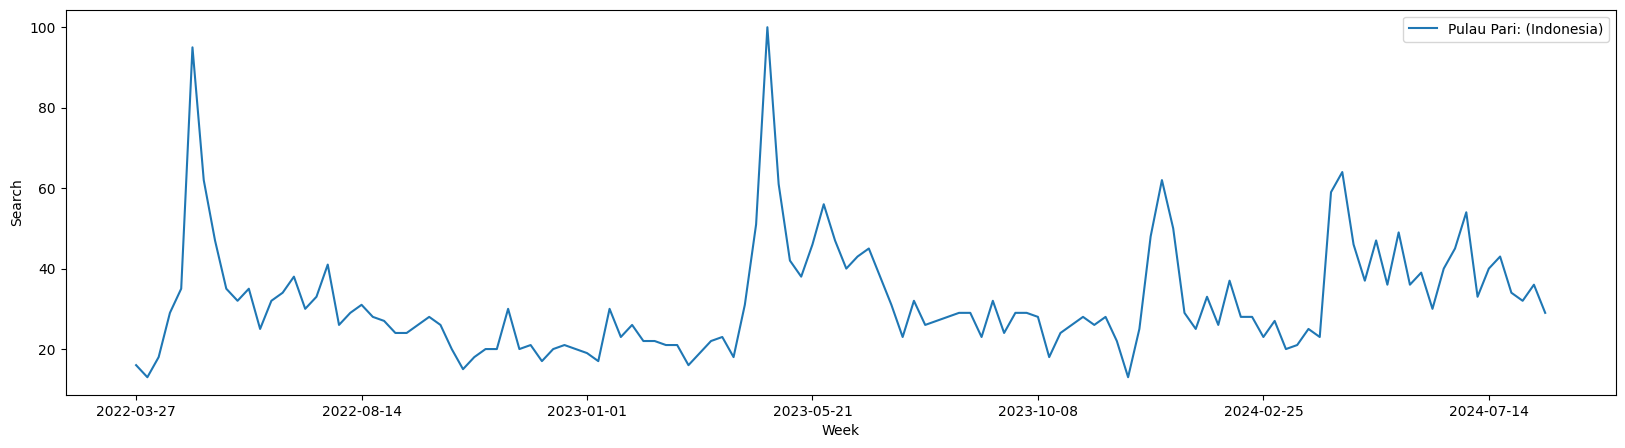

In [265]:
# plotting dataset
df['Pulau Pari: (Indonesia)'] = df['Pulau Pari: (Indonesia)'].astype(int)
df.plot(figsize=(20,5))
plt.xlabel('Week')
plt.ylabel('Search')
plt.show()

Dataset memiliki informasi sebanyak 126 data mingguan pencarian pulau pari, kenaikan pencarian terjadi disetiap tahun pada bulan Maret, dan perlahan menurun sampai bulan agustus. Secara gambaran umum, tren mengalami sedikit kenaikan.

In [266]:
# mengubah format datetime 
df.index = pd.to_datetime(df.index, format='%Y-%m-%d')

In [267]:
# Hitung selisih waktu antar baris
time_diffs = df.index.to_series().diff().dropna()

# Lihat beberapa selisih waktu
print(time_diffs.head(10))

2022-04-03   7 days
2022-04-10   7 days
2022-04-17   7 days
2022-04-24   7 days
2022-05-01   7 days
2022-05-08   7 days
2022-05-15   7 days
2022-05-22   7 days
2022-05-29   7 days
2022-06-05   7 days
dtype: timedelta64[ns]


In [268]:
# melakukan pengecekan frequency index
df = df.asfreq(pd.infer_freq(df.index))

frequency = pd.infer_freq(df.index)
print(frequency)

W-SUN


Dataset memiliki informasi persentase popularitas yang diambil dalam rentang waktu setiap satu minggu yang dimulai dari hari minggu per barisnya.

<Figure size 640x480 with 0 Axes>

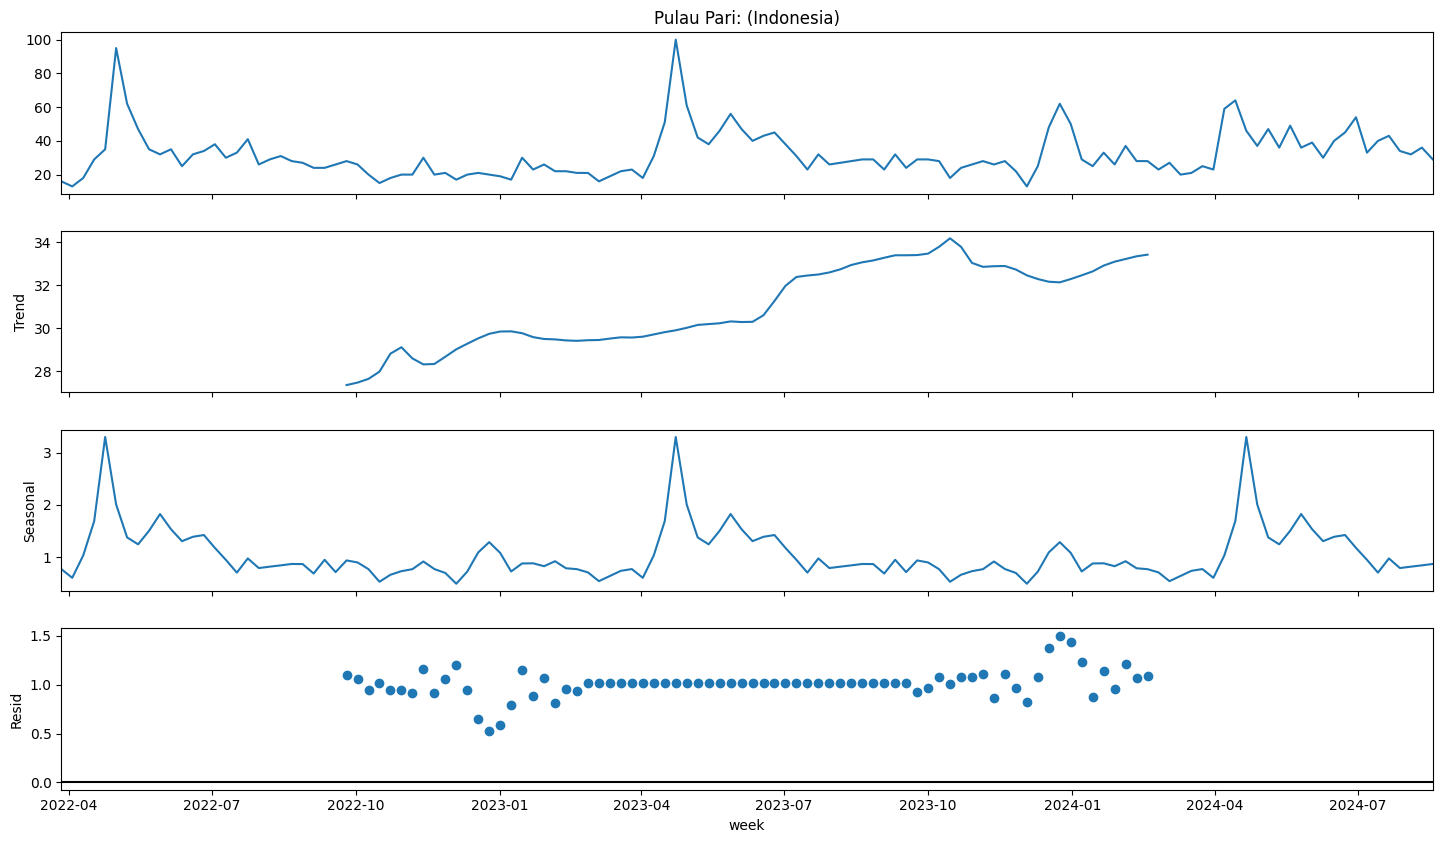

In [269]:
# decompose time series dengan model multiplicative
result = seasonal_decompose(df['Pulau Pari: (Indonesia)'], model='multiplicative') 
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)
plt.xlabel('week')
plt.show()

Dalam seasonal decompose time series pada dataset menggunakan model multiplicative, didapatkan output:
- tren cenderung mengalami kenaikan seiring waktu
- seasonality terjadi setiap satu tahun sekali pada bulan maret
- varians nilai residual / noise cenderung berdekatan

<Figure size 640x480 with 0 Axes>

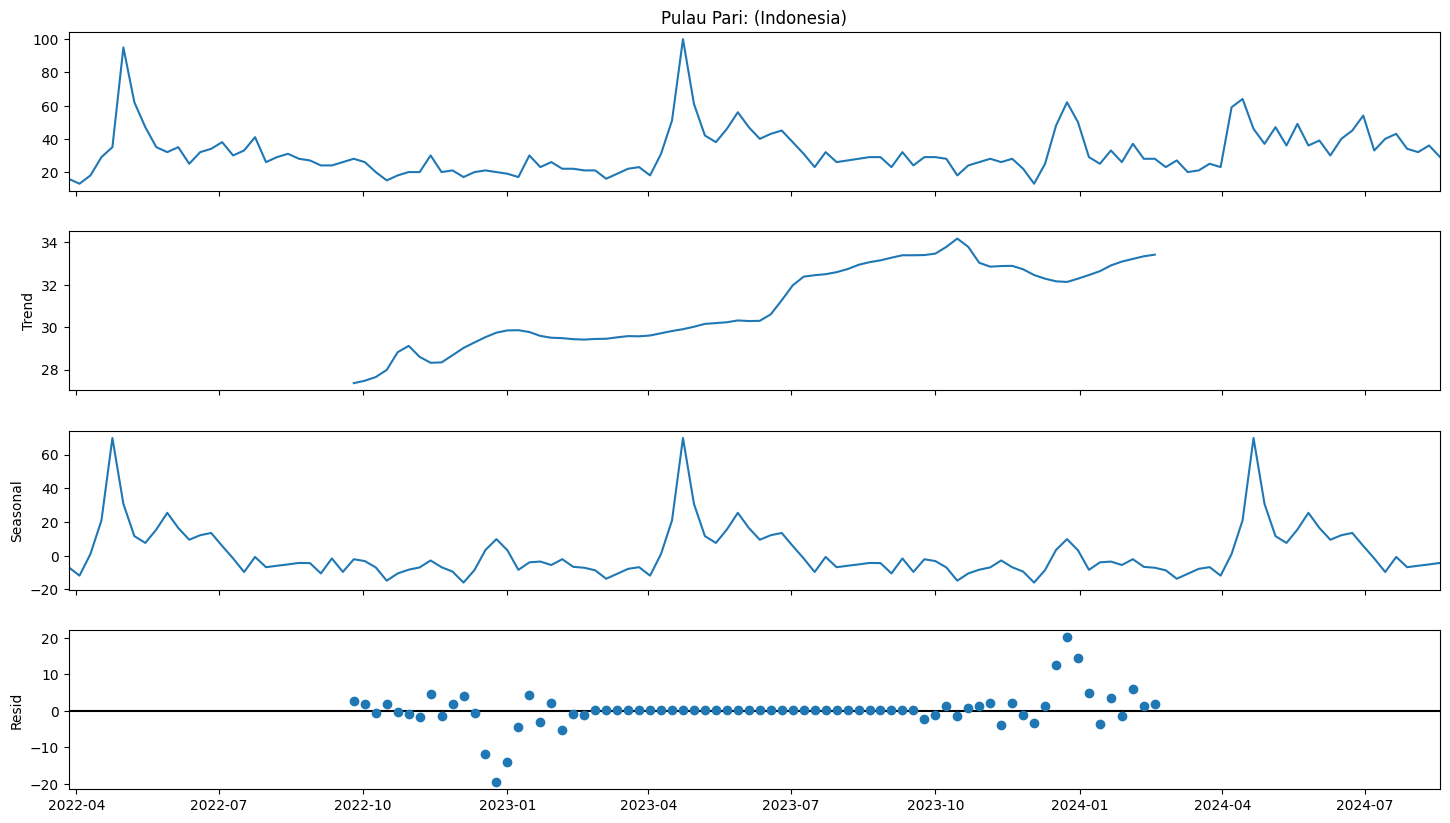

In [270]:
# decompose time series dengan model additive
result = seasonal_decompose(df['Pulau Pari: (Indonesia)'], model='additive') 
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)
plt.show()

Dalam seasonal decompose time series pada dataset menggunakan model additive, didapatkan output:
- tren cenderung mengalami kenaikan seiring waktu
- seasonality terjadi setiap satu tahun sekali pada bulan maret
- varians nilai residual / noise cenderung jauh dari nilai 0

In [271]:
# Create function to check stationarity
def check_stationarity(series):

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

# Modeling

## Split Train Test set

In [272]:
# Splitting dataset into train and test set
# 80%
train = df[:101]

# 20%
test = df[101:]

print('Train size : ', train.shape)
print('Test size : ', test.shape)

Train size :  (101, 1)
Test size :  (25, 1)


In [273]:
# cek stationarity trainset
check_stationarity(train)

ADF Statistic: -3.477037
p-value: 0.008597
Critical Values:
	1%: -3.500
	5%: -2.892
	10%: -2.583
Stationary


Dari output diatas didapatkan informasi bahwa data sudah berbentuk stationer sehingga tidak perlu dilakukan differencing, artinya nilai d pada model (p, d ,q) ARIMA akan bernilai 0

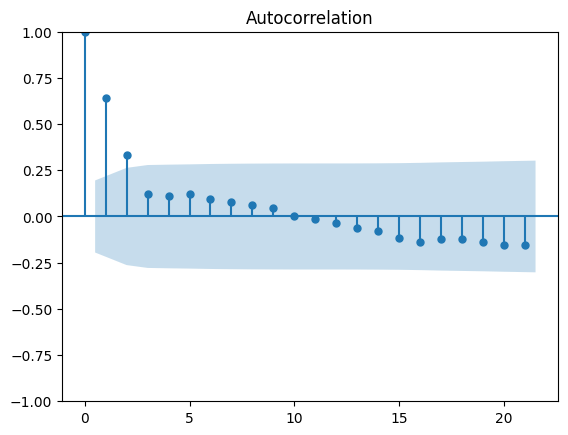

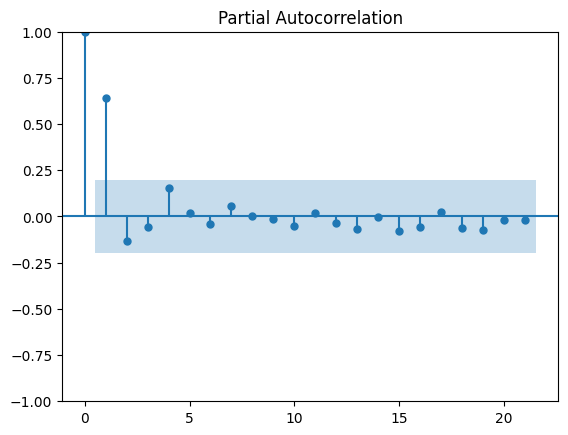

In [274]:
# Plot ACF & PACF from the original dataset

plot_acf(train)
plot_pacf(train)
plt.show()

Pada output diatas didapatkan informasi bahwa nilai partial autocorrelation untuk nilai AR (p) adalah 1 karena korelasi yang masih tinggi ada pada lag 1, untuk nilai MA (q) adalah 1 atau 2. Tetapi nanti akan dicoba mencari kombinasi terbaiknya untuk mendapatkan nilai AIC sekecil mungkin yang menandakan model bisa memprediksi dengan baik.

In [275]:
# Create a function to find best model

def find_best_model(data, num_p, num_d, num_q):
  df1 = pd.DataFrame() #We make a pandas dataframe to ease our work, you can use any way that makes you comfortable and work easly
  pdq = [[],[],[]] #This list for storing the combinations of p and q
  aic = [] # This list for storing aic value
  for p in range(num_p + 1): #plus one is to make the range up to num_p since python range only ranging from 0 to N-1
    for d in range(num_d + 1):
      for q in range(num_q + 1):
        # #if p!=0 and q!=0: #this logic will avoid (0,0) value which is not correct
        try: #Using exception to avoid the error while training the model with certain p and q value
          model = ARIMA(data, order=(p, d, q))
          result = model.fit()
          pdq[0].append(p)
          pdq[1].append(d)
          pdq[2].append(q)
          aic.append(result.aic)
        except:
          pass #If there is an error caused by the calculation, it will be skipped to the next iteration

  df1['p'] = pdq[0]
  df1['d'] = pdq[1]
  df1['q'] = pdq[2]
  df1['AIC'] = aic

  df1.sort_values('AIC', inplace=True)

  return df1.p.iloc[0], df1.d.iloc[0], df1.q.iloc[0], df1.AIC.iloc[0], df1

In [276]:
# mencari kombinasi dengan maksimal nilai p=2, d=2, q=2
find_best_model(train['Pulau Pari: (Indonesia)'], 2, 2, 2)

/opt/anaconda3/envs/phase1/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/phase1/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/phase1/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/phase1/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting 

(1,
 1,
 1,
 769.5455848460929,
     p  d  q         AIC
 13  1  1  1  769.545585
 22  2  1  1  770.148174
 14  1  1  2  770.415509
 23  2  1  2  772.086395
 2   0  0  2  772.200813
 11  1  0  2  773.402654
 9   1  0  0  773.594292
 18  2  0  0  773.950327
 10  1  0  1  774.302923
 20  2  0  2  775.377693
 19  2  0  1  775.849644
 5   0  1  2  777.879916
 7   0  2  1  781.208471
 3   0  1  0  781.405618
 4   0  1  1  782.586613
 8   0  2  2  782.617906
 16  1  2  1  782.801233
 12  1  1  0  782.860823
 21  2  1  0  782.902364
 25  2  2  1  783.107820
 17  1  2  2  784.481348
 26  2  2  2  785.890603
 1   0  0  1  786.478944
 24  2  2  0  823.417497
 0   0  0  0  825.178148
 15  1  2  0  827.531604
 6   0  2  0  850.184243)

## ARIMA

In [277]:
# Train ARIMA with best combinations
arima = ARIMA(train, order=(2, 1, 3)).fit()
print('The AIC is', arima.aic)

The AIC is 771.7635741591164


/opt/anaconda3/envs/phase1/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


dari hasil diatas didapatkan informasi bahwa nilai p,d,q dengan nilai (1,1,1) sebesar 769.5 dan nilai p,d,q(1,0,2) sesuai dengan yang ditentukan saat plotting ACF dan PACF masih lebih baik p,d,q yang bernilai (1,1,1). tetapi dengan mempertimbangkan nilai MAE dan MAPE yang lebih kecil. Selanjutnya akan dilakukan prediksi menggunakan data test dengan nilai p,d,q (2,1,3).

In [278]:
# Predict test-set
arima_pred_test = arima.predict(start='2024-03-03', end='2024-08-18')
arima_pred_test = pd.DataFrame(arima_pred_test)
arima_pred_test.columns=['Popularity_predict']

# Combine the actual test data and the predictions
act_vs_pred_arima = pd.concat([test, arima_pred_test], axis=1)

# Ensure the index is in datetime format
act_vs_pred_arima.index = pd.to_datetime(act_vs_pred_arima.index)

# Filter data for the date range
start_date = '2024-03-03'
end_date = '2024-08-18'
filtered_data1 = act_vs_pred_arima.loc[start_date:end_date]
filtered_data1

,Pulau Pari: (Indonesia),Popularity_predict
2024-03-03,27,26.090630
2024-03-10,20,28.206481
2024-03-17,21,29.932933
2024-03-24,25,30.292361
2024-03-31,23,30.353175
2024-04-07,59,30.362730
2024-04-14,64,30.364185
2024-04-21,46,30.364403
2024-04-28,37,30.364435
2024-05-05,47,30.364440


## SARIMAX

In [279]:
# Train SARIMAX with order based on pacf acf
sarimax = SARIMAX(train, order=(2, 1, 3),seasonal_order=(2, 1, 3, 52)).fit()
sarimax.summary()

/opt/anaconda3/envs/phase1/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.40966D+00    |proj g|=  5.10431D-01


 This problem is unconstrained.



At iterate    5    f=  2.08320D+00    |proj g|=  7.68464D-02

At iterate   10    f=  1.96059D+00    |proj g|=  6.59436D-02

At iterate   15    f=  1.94990D+00    |proj g|=  2.14669D-02

At iterate   20    f=  1.94487D+00    |proj g|=  2.06911D-02

At iterate   25    f=  1.93914D+00    |proj g|=  7.94342D-02

At iterate   30    f=  1.93649D+00    |proj g|=  2.04477D-02

At iterate   35    f=  1.93625D+00    |proj g|=  4.81811D-04

At iterate   40    f=  1.93625D+00    |proj g|=  6.54872D-04

At iterate   45    f=  1.93622D+00    |proj g|=  3.90710D-03


/opt/anaconda3/envs/phase1/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.93622D+00    |proj g|=  4.36919D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     58      1     0     0   4.369D-04   1.936D+00
  F =   1.9362197201474531     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:            Pulau Pari: (Indonesia)   No. Observations:                  101
Model:             SARIMAX(2, 1, 3)x(2, 1, 3, 52)   Log Likelihood                -195.558
Date:                            Mon, 23 Sep 2024   AIC                            413.116
Time:                                    11:59:57   BIC                            433.700
Sample:                                03-27-2022   HQIC                           420.895
                                     - 02-25-2024                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4512      0.273     -1.654      0.098      -0.986       0.084
ar.L2         -0.6190      0.244     -2.540      0.011      -1.097      -0.141
ma.L1         -0.2548     38.897     -0.007      0.995     -76.492      75.982
ma.L2          0.2455     28.775      0.009      0.993     -56.152      56.643
ma.L3         -0.9902     39.202     -0.025      0.980     -77.824      75.844
ar.S.L52      -0.1706      0.170     -1.005      0.315      -0.503       0.162
ar.S.L104     -0.0148      0.072     -0.206      0.837      -0.156       0.126
ma.S.L52      -0.1659    149.924     -0.001      0.999    -294.011     293.680
ma.S.L104      0.0033    347.139   9.43e-06      1.000    -680.376     680.382
ma.S.L156     -0.0264    406.704  -6.49e-05      1.000    -797.152     797.099
sigma2       157.1290     53.935      2.913      0.004      51.419     262.839
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                93.80
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.30   Skew:                            -0.78
Prob(H) (two-sided):                  0.02   Kurtosis:                         9.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.44e+17. Standard errors may be unstable.
"""

In [280]:
# Predict test-set 
sar_pred_test = sarimax.predict(start='2024-03-03', end='2024-08-18')
sar_pred_test = pd.DataFrame(sar_pred_test)
sar_pred_test.columns=['Popularity_predict']

# Combine the actual test data and the predictions
act_vs_pred_sar = pd.concat([test, sar_pred_test], axis=1)

# Ensure the index is in datetime format
act_vs_pred_sar.index = pd.to_datetime(act_vs_pred_sar.index)

# Filter data for the date range '2024-03-03', end='2024-08-18'
start_date = '2024-03-03'
end_date = '2024-08-18'
filtered_data2 = act_vs_pred_sar.loc[start_date:end_date]
filtered_data2

,Pulau Pari: (Indonesia),Popularity_predict
2024-03-03,27,24.524509
2024-03-10,20,26.148755
2024-03-17,21,24.310191
2024-03-24,25,29.827300
2024-03-31,23,24.307071
2024-04-07,59,35.191037
2024-04-14,64,52.867496
2024-04-21,46,87.757424
2024-04-28,37,79.999777
2024-05-05,47,56.920635


# Model Evaluation

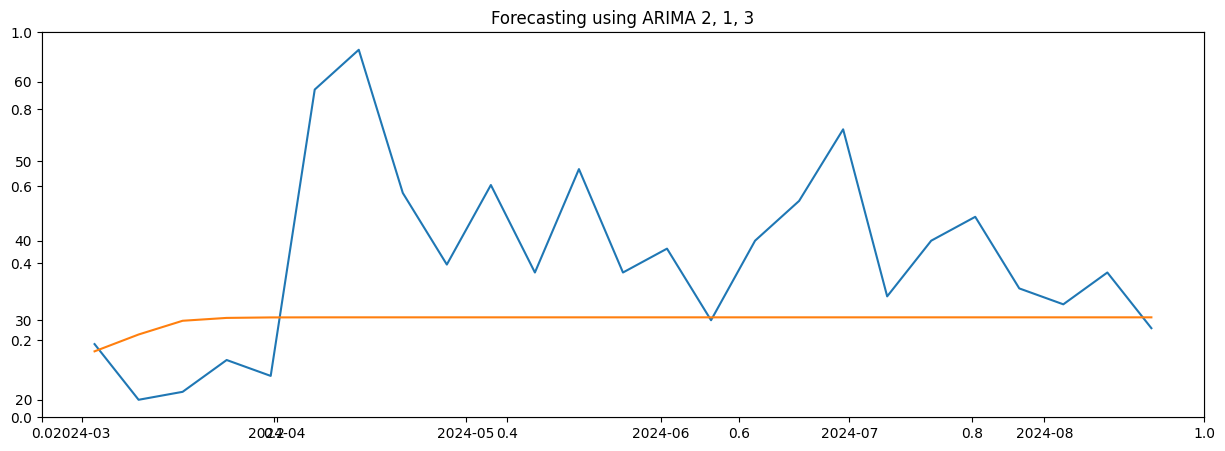

In [281]:
# Plot all dataset including prediction

fig, ax = plt.subplots(figsize=(15,5))
ax1 = fig.add_subplot(111)
ax1.set_title('Forecasting using ARIMA 2, 1, 3')
ax1.plot(filtered_data1)

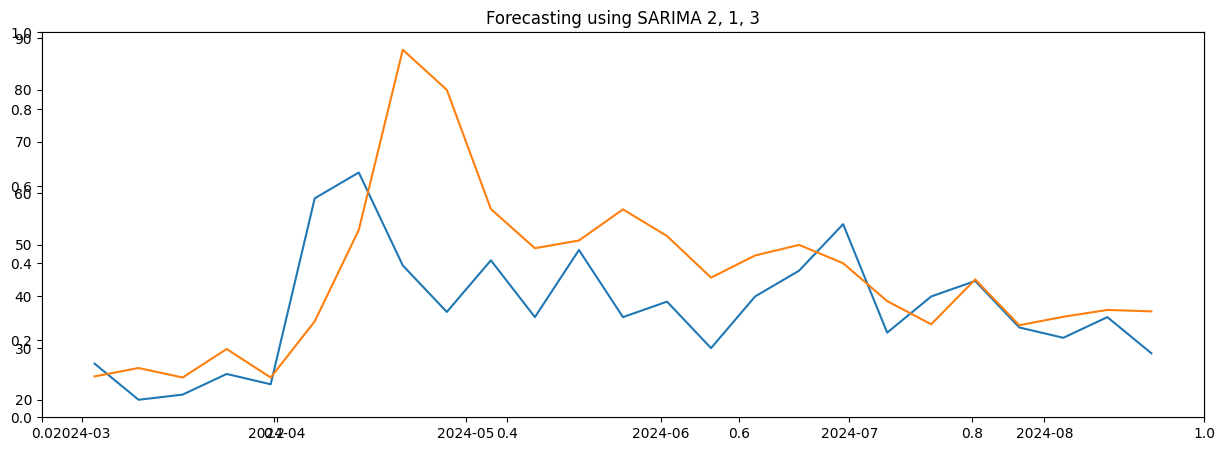

In [282]:
# Plot all dataset including prediction

fig, ax = plt.subplots(figsize=(15,5))
ax1 = fig.add_subplot(111)
ax1.set_title('Forecasting using SARIMA 2, 1, 3')
ax1.plot(filtered_data2)

In [283]:
# check the MAE
print('MAE test  : ', mean_absolute_error(test, arima_pred_test))
# check the MAE
print('MAE Percentage test  : ', mean_absolute_percentage_error(test, arima_pred_test)*100,"%")

MAE test  :  10.234611156463666
MAE Percentage test  :  24.767767746409422 %


In [284]:
# check the MAE
print('MAE test  : ', mean_absolute_error(test, sar_pred_test))
# check the MAE
print('MAE Percentage test  : ', mean_absolute_percentage_error(test, sar_pred_test)*100,"%")

MAE test  :  10.253602103271954
MAE Percentage test  :  26.667899187051813 %


Dari hasil evaluasi diatas, didapatkan informasi bahwa nilai MAE dan MAPE model ARIMA dan SARIMA tidak terpaut jauh, tetapi karena ada seasonality, maka model SARIMA lebih baik dalam menangkap seasonality walaupun score MAE dan MAPE nya lebih tinggi daripada model ARIMA. Sehingga model yang akan digunakan untuk memprediksi popularity keyword search akan menggunakan model SARIMA dengan nilai p=2, d=1, q=3.

# Forecast 1 Minggu

In [287]:
# Predict next 7 days

len_dataset = df.shape[0]
len_predict = len_dataset + 52

new_pred = sarimax.predict(len_dataset, len_predict)
new_pred = pd.DataFrame(new_pred)
new_pred.columns=['Pulau Pari: (Indonesia)']
all_dataset_with_pred = pd.concat([df, new_pred], axis=0)

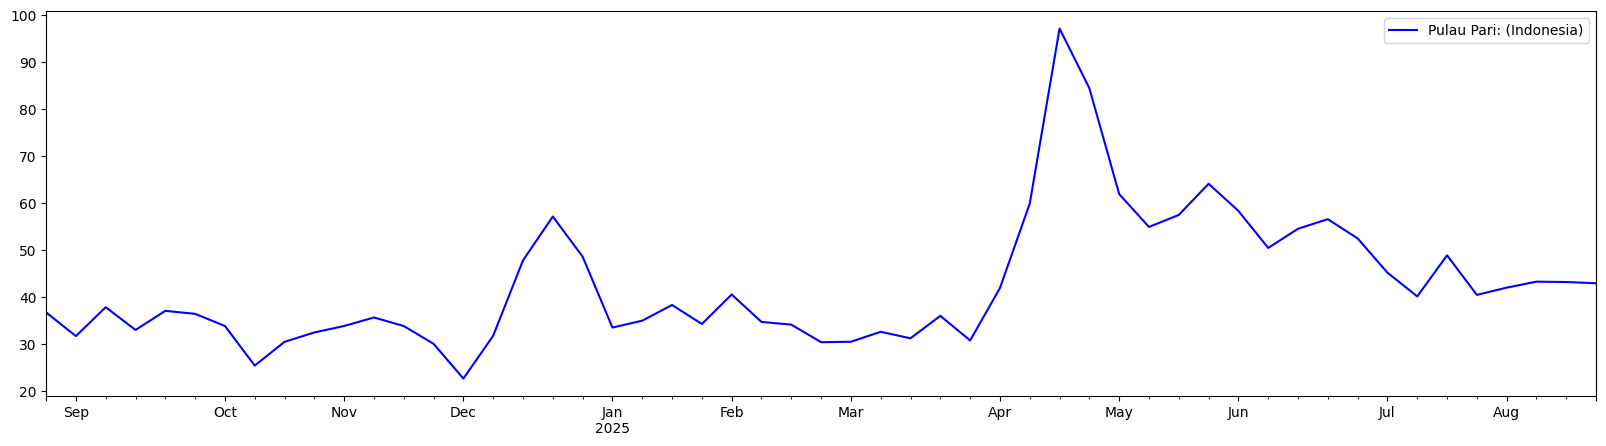

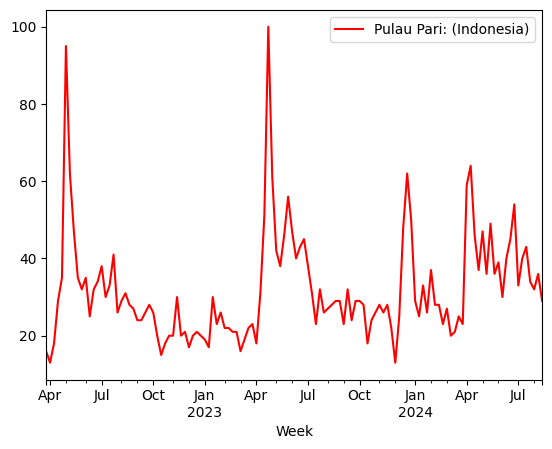

In [288]:
# make a forecast
new_pred.plot(color='blue', label = 'forecast',figsize=(20,5))
df.plot(color='red',label = 'real')
plt.xlabel('Week')
plt.legend()

# Kesimpulan

Dari hasil prediksi SARIMA, dalam satu tahun kedepan akan terjadi kenaikan dalam bulan maret dalam keyword search Pulau Pari, jika dibandingkan dengan plot data aktual maka seasonalitynya sedikit bergesar ke bulan April.